In [1]:
import math
import torch
import transformers

device = torch.device("cpu")

image_processor = transformers.AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = transformers.ResNetModel.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
import PIL

def content_loss(a, b):
    diff2 = (a - b) / 2
    diff2 = diff2 * diff2
    return torch.sum(diff2)

def gram(layer):
    shape = layer.shape
    features = layer.reshape((shape[0], shape[1], shape[2] * shape[3]))
    g = torch.matmul(features, features.transpose(1, 2))
    return g

def style_loss(a, b):
    a_gram, b_gram = gram(a), gram(b)
    diff2 = (a_gram - b_gram) / 2 / a.shape[1] / a.shape[2] / a.shape[3]
    diff2 = diff2 * diff2
    return torch.sum(diff2)

dog = PIL.Image.open('dog6.jpeg')
time = PIL.Image.open('dog_sketch2.jpeg')
#dog.show()
print(dog.size)

dog_inputs = image_processor(dog, return_tensors="pt")["pixel_values"]
time_inputs = image_processor(time, return_tensors="pt")["pixel_values"]
print(dog_inputs.shape)
with torch.no_grad():
    dog_outputs = model(dog_inputs, output_hidden_states = True)
    time_outputs = model(time_inputs, output_hidden_states = True)

for dog_state, time_state in zip(dog_outputs.hidden_states, time_outputs.hidden_states):
    print(content_loss(dog_state, time_state))
    print(style_loss(dog_state, time_state))
    print("")    

(255, 198)
torch.Size([1, 3, 224, 224])
tensor(303432.8125)
tensor(16.5539)

tensor(115406.0625)
tensor(0.0096)

tensor(404335.9062)
tensor(0.2695)

tensor(135029.3125)
tensor(0.1990)

tensor(3944.4194)
tensor(0.0007)



In [3]:
for name, param in model.named_parameters():
    print(name)
    param.requires_grad = False

embedder.embedder.convolution.weight
embedder.embedder.normalization.weight
embedder.embedder.normalization.bias
encoder.stages.0.layers.0.shortcut.convolution.weight
encoder.stages.0.layers.0.shortcut.normalization.weight
encoder.stages.0.layers.0.shortcut.normalization.bias
encoder.stages.0.layers.0.layer.0.convolution.weight
encoder.stages.0.layers.0.layer.0.normalization.weight
encoder.stages.0.layers.0.layer.0.normalization.bias
encoder.stages.0.layers.0.layer.1.convolution.weight
encoder.stages.0.layers.0.layer.1.normalization.weight
encoder.stages.0.layers.0.layer.1.normalization.bias
encoder.stages.0.layers.0.layer.2.convolution.weight
encoder.stages.0.layers.0.layer.2.normalization.weight
encoder.stages.0.layers.0.layer.2.normalization.bias
encoder.stages.0.layers.1.layer.0.convolution.weight
encoder.stages.0.layers.1.layer.0.normalization.weight
encoder.stages.0.layers.1.layer.0.normalization.bias
encoder.stages.0.layers.1.layer.1.convolution.weight
encoder.stages.0.layers.1.

torch.Size([1, 3, 224, 224])
3811.90771484375
3531.282470703125
3450.830322265625
3397.42626953125
3357.75048828125
3337.8701171875
3318.2763671875
3302.012939453125
3289.092041015625
3278.043212890625
3270.180419921875
3260.23974609375
3252.814208984375
3245.1953125
3239.13037109375
3233.810546875
3227.740966796875
3222.394287109375
3217.725830078125
3212.921142578125
3209.609130859375
3206.69970703125
3201.75732421875
3200.6103515625
3194.34130859375
3191.48291015625
3187.3017578125
3183.98095703125
3180.13330078125
3177.151611328125
3174.299560546875
3171.923583984375
3168.75341796875
3165.5224609375
3162.983154296875
3161.15283203125
3157.75927734375
3153.84375
3151.068603515625
3149.0615234375
3146.907958984375
3143.247802734375
3139.908203125
3138.093505859375
3135.77392578125
3131.97412109375
3129.03759765625
3127.46533203125
3127.13037109375
3119.18115234375
3121.7939453125
3115.925537109375
3109.290283203125
3098.609375
3091.7939453125
3084.76318359375
3080.568603515625
3070.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2898.68017578125


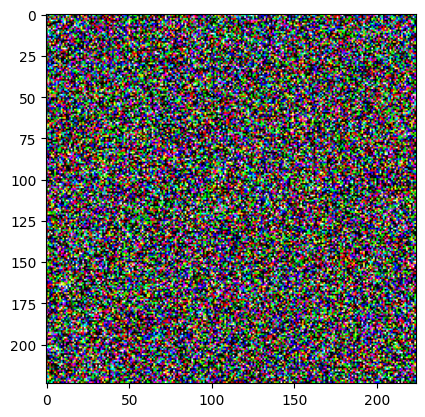

In [38]:
import matplotlib.pyplot as plt

img = torch.randn((1, 3, 224, 224), requires_grad=True)
print(img.shape)

content_target = PIL.Image.open('dog6.jpeg')
style_target = PIL.Image.open('dog_sketch2.jpeg')
content_inputs = image_processor(content_target, return_tensors="pt")["pixel_values"]
style_inputs = image_processor(style_target, return_tensors="pt")["pixel_values"]
content_outputs = model(content_inputs, output_hidden_states = True)
style_outputs = model(style_inputs, output_hidden_states = True)

optimiser = torch.optim.Adam([img], lr = 1e-2, eps = 1e-12)
for _ in range(100):
    optimiser.zero_grad()
    img_outputs = model(img, output_hidden_states = True)
    loss = content_loss(img_outputs.hidden_states[4], style_outputs.hidden_states[4])
    print(loss.item())
    loss.backward()
    optimiser.step()

plt.imshow(img.squeeze(0).permute(1, 2, 0).detach().numpy())
plt.show()